In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/cleaned_employee_learning_data.csv'


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import xgboost as xgb

# Set global aesthetics
warnings.filterwarnings('ignore')
sns.set_theme(style="white", palette="husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# 1. LOAD AND PREPROCESS DATA
df = pd.read_csv(file_path)

# Ensure dates are in datetime format for time-based analysis
date_columns = ['start_date', 'completion_date', 'last_login_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print("Current Dataset Columns:")
print(df.columns.tolist())
print("-" * 50)

# Handle missing values (Cleaning)
df['score'] = df['score'].fillna(df['score'].median())
df['feedback_rating'] = df['feedback_rating'].fillna(df['feedback_rating'].median())
df['status_val'] = df['completion_status'].map({'Completed': 1, 'Incomplete': 0.5, 'Dropped': 0})



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Dataset Columns:
['employee_id', 'department', 'role_level', 'training_module_id', 'module_name', 'module_type', 'start_date', 'completion_date', 'completion_status', 'score', 'feedback_rating', 'time_spent_minutes', 'preferred_learning_style', 'last_login_date']
--------------------------------------------------


## Exploratory Data Analysis

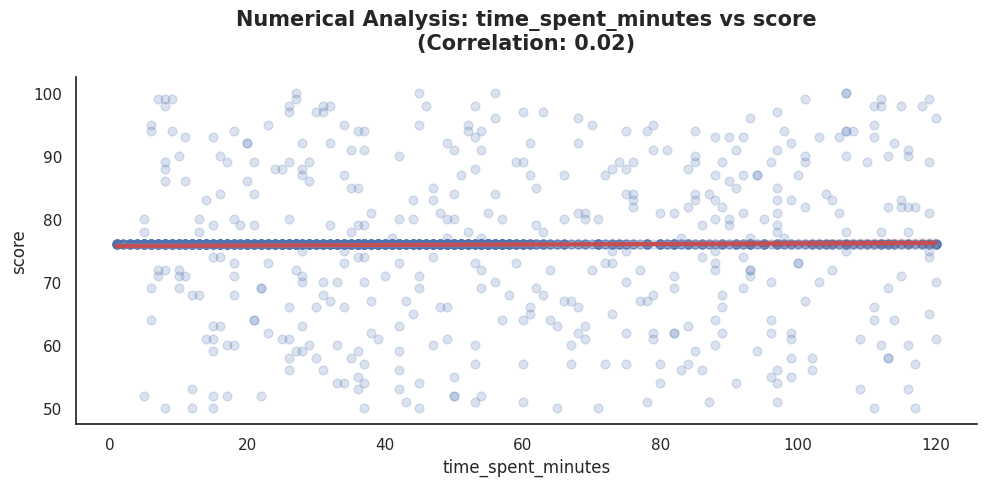

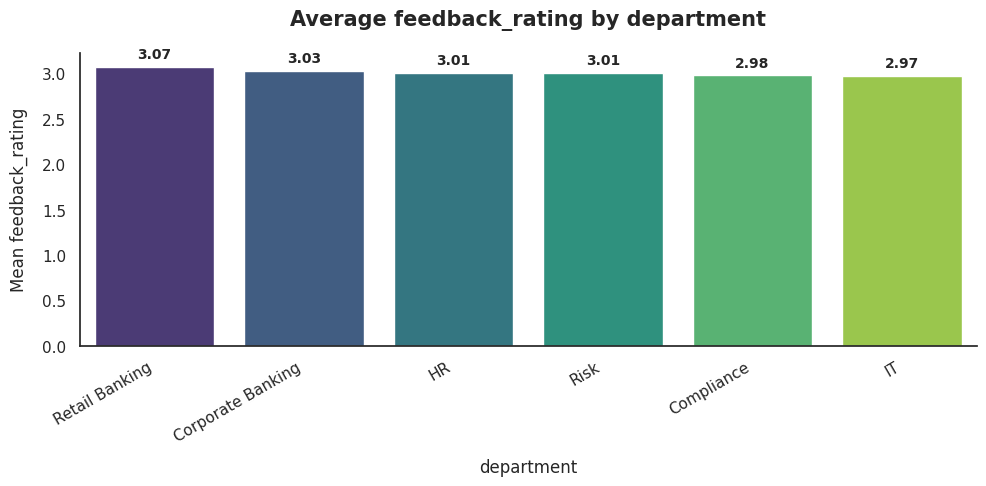

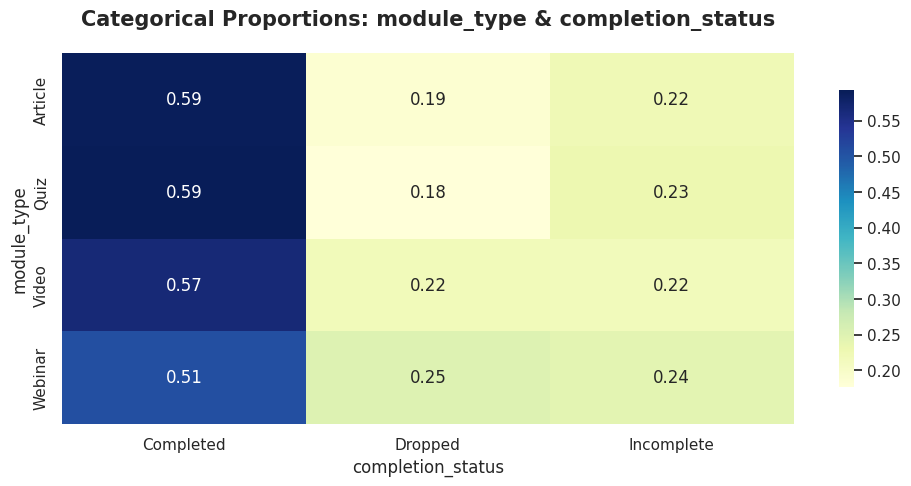

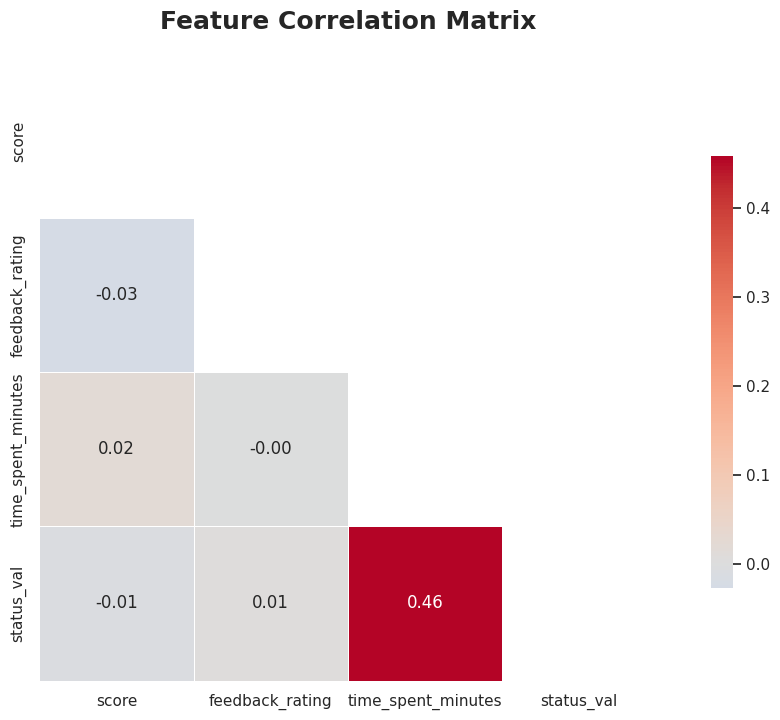

In [ ]:

def visualize_relationship(df, feat1, feat2):
    """
    A visualization function with adaptive plot types (Regression, Bar, Heatmap).
    """
    is_num1 = pd.api.types.is_numeric_dtype(df[feat1])
    is_num2 = pd.api.types.is_numeric_dtype(df[feat2])

    plt.figure(figsize=(11, 6))

    if is_num1 and is_num2:
        # Case A: Numeric vs Numeric (Regression)
        sns.regplot(data=df, x=feat1, y=feat2,
                    scatter_kws={'alpha':0.2, 's':40, 'color':'#4C72B0'},
                    line_kws={'color':'#C44E52', 'lw':3})
        corr = df[[feat1, feat2]].corr().iloc[0, 1]
        plt.title(f"Numerical Analysis: {feat1} vs {feat2}\n(Correlation: {corr:.2f})",
                     fontsize=15, fontweight='bold', pad=20)

    elif (is_num1 and not is_num2) or (not is_num1 and is_num2):
        # Case B: Numeric vs Categorical (Bar Plot of Means)
        num_feat, cat_feat = (feat1, feat2) if is_num1 else (feat2, feat1)
        order = df.groupby(cat_feat)[num_feat].mean().sort_values(ascending=False).index

        ax = sns.barplot(data=df, x=cat_feat, y=num_feat, palette='viridis', ci=None, order=order)

        # Add value labels on top of bars
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9), textcoords = 'offset points',
                       fontsize=10, fontweight='bold')

        plt.xticks(rotation=30, ha='right')
        plt.title(f"Average {num_feat} by {cat_feat}", fontsize=15, fontweight='bold', pad=20)
        plt.xlabel(cat_feat, fontsize=12, labelpad=10)
        plt.ylabel(f"Mean {num_feat}", fontsize=12, labelpad=10)

    else:
        # Case C: Categorical vs Categorical (Heatmap)
        ct = pd.crosstab(df[feat1], df[feat2], normalize='index')
        sns.heatmap(ct, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'shrink': .8})
        plt.title(f"Categorical Proportions: {feat1} & {feat2}", fontsize=15, fontweight='bold', pad=20)

    plt.tight_layout(pad=4.0)
    plt.show()
    print("\n\n")

# Demonstrate usage of the general function
visualize_relationship(df, 'time_spent_minutes', 'score')      # Numeric vs Numeric
visualize_relationship(df, 'department', 'feedback_rating')   # Categorical vs Numeric
visualize_relationship(df, 'module_type', 'completion_status') # Categorical vs Categorical

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
mask = np.triu(np.ones_like(numeric_df.corr(), dtype=bool)) # Show only half the matrix
sns.heatmap(numeric_df.corr(), mask=mask, annot=True, cmap='coolwarm',
            fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Feature Correlation Matrix', fontsize=18, fontweight='bold', pad=25)
plt.tight_layout(pad=3.0)
plt.show()



## Determining Feature Importance


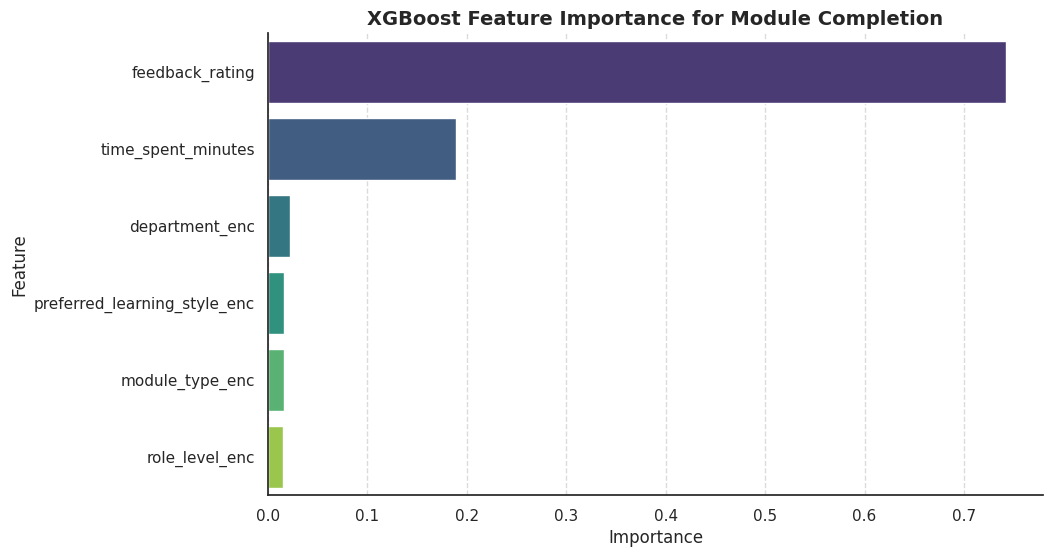

Top Features identified by XGBoost:
                        Feature  Importance
4               feedback_rating    0.742309
5            time_spent_minutes    0.188799
0                department_enc    0.021969
3  preferred_learning_style_enc    0.016484
2               module_type_enc    0.015660
1                role_level_enc    0.014780


In [ ]:
# 1. PREPARE DATA
le = LabelEncoder()
df_model = df.copy()

# Categorical columns to encode
categorical_features = ['department', 'role_level', 'module_type', 'preferred_learning_style']
for col in categorical_features:
    df_model[f'{col}_enc'] = le.fit_transform(df_model[col].astype(str))

# Define Features and Target
feature_cols = [f'{c}_enc' for c in categorical_features] + ['feedback_rating', 'time_spent_minutes']

X = df_model[feature_cols]
y = (df_model['completion_status'] == 'Completed').astype(int)

# 2. INITIALIZE AND TRAIN XGBOOST
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X, y)

# 3. EXTRACT FEATURE IMPORTANCE
# XGBoost offers different types of importance; 'gain' is usually the most informative
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. VISUALIZE
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance for Module Completion', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Top Features identified by XGBoost:")
print(feat_imp_df)


##  Personas:

1. The Efficient Expert
Profile: High Score | Low Time Spent | Low Completion Rate

This learner likely already possesses a high level of prior knowledge. They jump into a module, quickly pass the assessments (High Score) to prove competency, and then exit without finishing the rest of the material (Low Completion). They value brevity and efficiency over a guided journey.

2. The Persistent Voyager
Profile: Low Score | High Course Volume | Higher Time Spent

This learner is extremely hardworking and curious, evidenced by taking a high number of courses. However, they may be struggling with the complexity of the material or are in a role that is a "stretch" for them. They are putting in the hours and the effort, but it isn't translating into high scores yet.

3. The Deep-Dive Scholar
Profile: High Completion | High Feedback | Highest Time Spent

This is your "model student." They don't just want the answer; they want the full experience. They spend the most time engaging with the content, finish every module they start, and provide high feedback because they are genuinely deriving value from the learning journey.

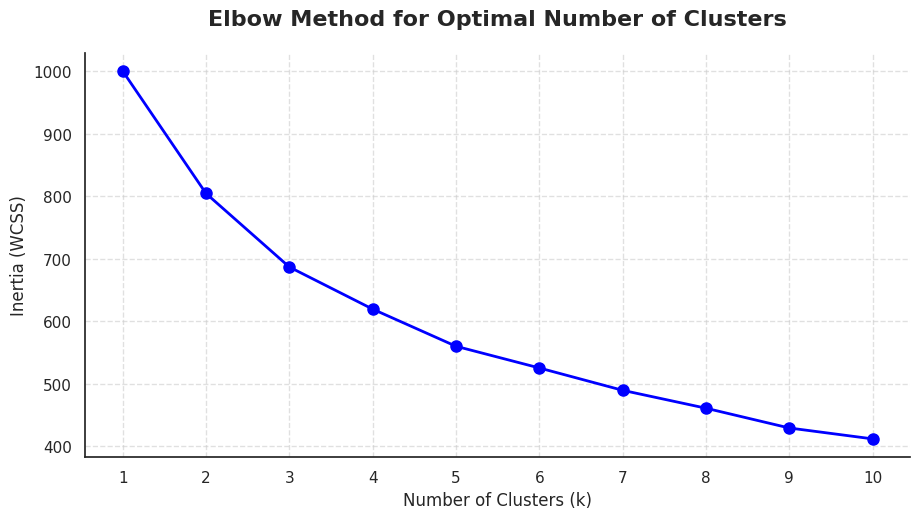

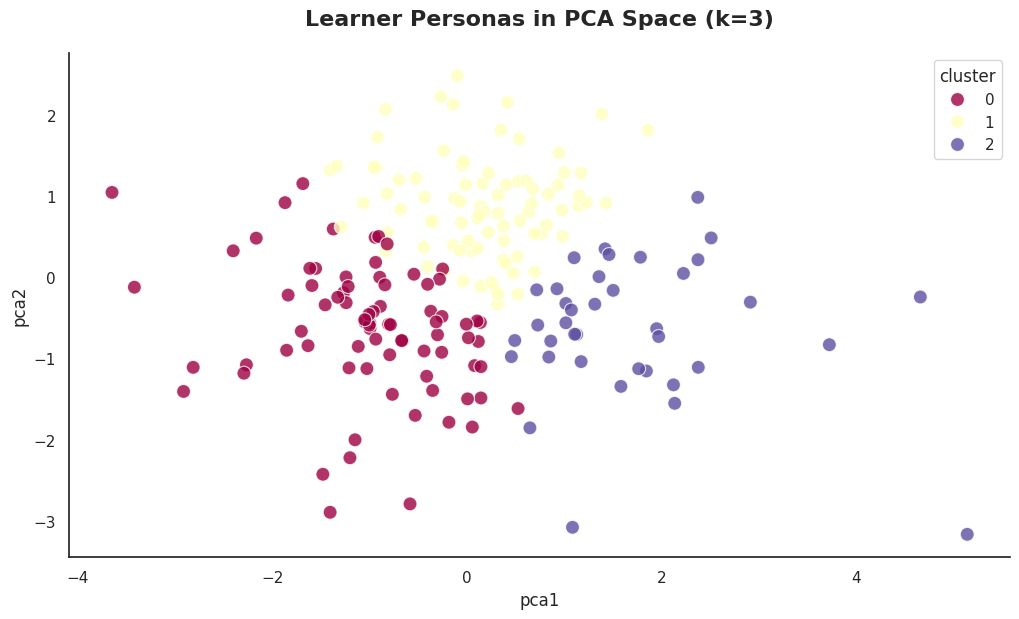


--- Cluster Attribute Summary (Means) ---
             score  time_spent_minutes  feedback_rating  completion_rate  \
cluster                                                                    
0        77.131743           42.439992         3.048070         0.592391   
1        74.935570           49.112728         2.875733         0.696303   
2        75.806028           60.010424         3.248197         0.831328   

         courses_taken  
cluster                 
0            10.192308  
1            12.535714  
2            10.447368  


In [ ]:
user_agg = df.groupby('employee_id').agg({
    'score': 'mean',
    'time_spent_minutes': 'mean',
    'feedback_rating': 'mean',
    'status_val': 'mean',
    'training_module_id': 'count'
}).rename(columns={'status_val': 'completion_rate', 'training_module_id': 'courses_taken'})

# Scale for clustering
scaler_cluster = StandardScaler()
user_scaled = scaler_cluster.fit_transform(user_agg)

# Elbow Method
inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(user_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-', markersize=8, lw=2)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(pad=3.0)
plt.show()
print("\n\n")
# Apply Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
user_agg['cluster'] = kmeans.fit_predict(user_scaled)
persona_mapping = {
    0: 'Efficient Expert',
    1: 'Persistent Voyager',
    2: 'Deep-Dive Scholar'
}

user_agg['persona'] = user_agg['cluster'].map(persona_mapping)
df = df.merge(user_agg[['persona']], on='employee_id', how='left')

# PCA Visualization
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_scaled)
user_agg['pca1'], user_agg['pca2'] = user_pca[:, 0], user_pca[:, 1]

plt.figure(figsize=(11, 7))
sns.scatterplot(data=user_agg, x='pca1', y='pca2', hue='cluster', palette='Spectral', s=100, alpha=0.8, edgecolor='w')
plt.title(f'Learner Personas in PCA Space (k={optimal_k})', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout(pad=3.0)
plt.show()

# Cluster Attribute Summary (Including Courses Taken)
print("\n Cluster Attribute Summary (Means)")
cluster_summary = user_agg.groupby('cluster')[['score', 'time_spent_minutes', 'feedback_rating', 'completion_rate', 'courses_taken']].mean()
print(cluster_summary)



## Calculation of Recommendation Score

In [ ]:
scaler_norm = MinMaxScaler()
df['feedback_rating_norm'] = scaler_norm.fit_transform(df[['feedback_rating']])
df['time_spent_minutes_norm'] = scaler_norm.fit_transform(df[['time_spent_minutes']])

# Learning Style Match (Video=Auditory, Article=Reading, Quiz=Kinesthetic)
def calculate_style_match(row):
    style = str(row['preferred_learning_style']).lower()
    m_type = str(row['module_type']).lower()
    if m_type == 'video' and 'auditory' in style: return 1
    if m_type == 'article' and 'reading' in style: return 1
    if m_type == 'quiz' and 'kinesthetic' in style: return 1
    return 0

df['style_match'] = df.apply(calculate_style_match, axis=1)

# Weight Optimization
target_vars = ['status_val', 'time_spent_minutes', 'feedback_rating']
best_combined_corr = -np.inf
best_weights = (0, 0, 0)

for wf in np.arange(0, 1.05, 0.05):
    for wt in np.arange(0, 1.05 - wf, 0.05):
        wm = round(1.0 - wf - wt, 2)
        if wm < 0: continue

        rec_score = (df['feedback_rating_norm'] * wf) + \
                    (df['time_spent_minutes_norm'] * wt) + \
                    (df['style_match'] * wm)

        combined_corr = np.mean([rec_score.corr(df[v]) for v in target_vars])
        if combined_corr > best_combined_corr:
            best_combined_corr = combined_corr
            best_weights = (wf, wt, wm)

wf_opt, wt_opt, wm_opt = best_weights
print(f"Optimized Weights -> Feedback: {wf_opt:.2f}, Time: {wt_opt:.2f}, Style Match: {wm_opt:.2f}")

# Calculate Final Scores
df['final_recommendation_score'] = (df['feedback_rating_norm'] * wf_opt) + \
                                   (df['time_spent_minutes_norm'] * wt_opt) + \
                                   (df['style_match'] * wm_opt)


module_recommendations = df.groupby(['persona', 'module_name', 'module_type'])['final_recommendation_score'].mean().reset_index()

top_recs = (
    module_recommendations.sort_values(['persona', 'final_recommendation_score'], ascending=[True, False])
    .groupby('persona')
    .head(5)
)

print("\n--- Top 5 Recommended Modules per Persona ---")
print(top_recs.reset_index(drop=True))

Optimized Weights -> Feedback: 0.40, Time: 0.60, Style Match: -0.00

--- Top 5 Recommended Modules per Persona ---
               persona module_name module_type  final_recommendation_score
0    Deep-Dive Scholar    Module 5        Quiz                    0.651755
1    Deep-Dive Scholar   Module 14        Quiz                    0.623709
2    Deep-Dive Scholar   Module 10       Video                    0.594865
3    Deep-Dive Scholar    Module 6        Quiz                    0.571345
4    Deep-Dive Scholar   Module 23     Webinar                    0.559477
5     Efficient Expert   Module 10       Video                    0.498487
6     Efficient Expert   Module 14        Quiz                    0.463127
7     Efficient Expert   Module 11       Video                    0.449223
8     Efficient Expert    Module 8       Video                    0.446555
9     Efficient Expert    Module 1       Video                    0.445333
10  Persistent Voyager    Module 6        Quiz              